<a href="https://colab.research.google.com/github/aasyngier/machine-learning/blob/main/ml_homework13and14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **HOMEWORK ASSIGNMENT DESCRIPTION AND INSTRUCTIONS**

### **Online Dataset**

The code provided below generates an *online* dataset `OddXYDataset`.

The term *online* means that the dataset does not have a fixed set of pre-generated examples (like a traditional training set of fixed size). Instead, new samples are generated dynamically each time they are requested.

While the number of possible examples is finite in principle, it is so large that — for practical purposes — we can consider it to be effectively infinite.

In this setting, there is no need to use a separate validation or test set: the training error itself is a good estimate of the generalization error, since every training sample is new and unseen.

Consequently, the notion of an *epoch* becomes a matter of convention. For this assignment, we define one epoch as processing 25,000 training examples.

### **Training strategies**

Overfitting is not a problem in the *online* setting — but training can still stagnate in local minima or flat regions of the loss landscape.  
To address this, you will likely need to try one or more of the following strategies:

- **Multiple restarts** with different random seed values;
- **Adaptive learning rate** — consider researching training schedulers (this topic was not covered in class);
- **Progressive model growth** — start with a simpler architecture and gradually add components during training,
  so that the parts already present can learn what to do before the rest is introduced.

### **DataLoader**

The `show_examples()` function demonstrate how to wrap the dataset into a `torch.utils.data.DataLoader` so it becomes directly usable for the training/testing of a neural network.

### **Data Description**

By examining the provided code and a few sample images generated from this dataset, you will notice that:

1. **Each data sample** is a 64×64 black-and-white image with the following characteristics:
  - It contains several shapes of the same type (either circles, triangles, or squares), randomly placed and varying in size;
  - It includes one additional shape of a different type — the *odd* shape — also placed at a random location;
  
  **Note that these shapes may overlap partially or even completely, potentially hiding the odd shape.**

2. **The label** associated with each image is a 2D point indicating the coordinates of the center of the odd shape.

### **The Homework Objective**

Students should design an architecture of an **attention-based neural network** and train it so that it attains an RMSE (Root Mean Square Error, defined as the square root of the MSE) of **5.0 or lower**. Due to the nature of the online dataset, there is no need to test the solution on a separate test set.

Students should visualize the attention matrices in the trained network and **discuss what they observe** — not just describe them.  
Focus on interpreting the patterns: Where is the model attending? Are there any consistent behaviors across samples? Does attention correlate with the position of the odd shape? What do surprising or unclear patterns tell us?

A few technical requirements to observe:

- Seed all random number generators so that (1) your results are replicable and (2) I can rerun your solution and obtain the same output — *in case I need to check something*.

- Make sure your Colab file contains a **fully trained solution** with:
  - printed training output,
  - attention diagrams,
  - and a plot of the training loss curve.

This way, I don’t have to rerun your code unless absolutely necessary.

### **Publish on GitHub**
- Upload your Colab notebook to your **GitHub repository** for this course.
- In your repository’s **README**, include a **link** to the notebook.
- In the notebook include **“Open in Colab”** badge so the notebook can be launched directly from GitHub.

In [2]:
import math, random, os, time, itertools, json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

SEED = 42
seed_everything(SEED)

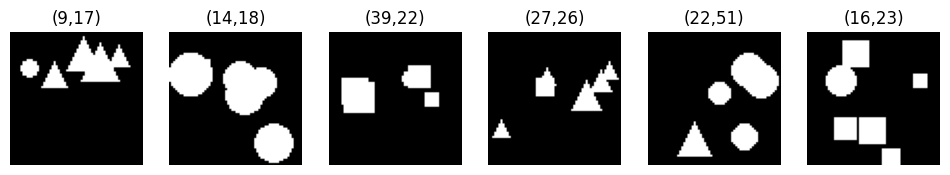

In [4]:
IMAGE         = 64
MIN_SHAPES    = 4
MAX_SHAPES    = 7
SHAPES        = ("circle", "square", "triangle")
BG, FG        = 0, 1

class OddXYDataset(Dataset):
    """
    Returns:
      image: torch.FloatTensor of shape (1, 64, 64)
      label: torch.FloatTensor of shape (2,)  (cx, cy)
    """
    def __init__(self, length=25_000): self.length = length
    def __len__(self):                 return self.length

    def _rand_circle(self, d: ImageDraw):
        r = random.randint(4,10)
        x,y = random.randint(r,IMAGE-r), random.randint(r,IMAGE-r)
        d.ellipse((x-r,y-r,x+r,y+r), fill=FG)
        return x,y
    def _rand_square(self, d: ImageDraw):
        s = random.randint(6,16)
        x,y = random.randint(s//2,IMAGE-s//2), random.randint(s//2,IMAGE-s//2)
        d.rectangle((x-s//2,y-s//2,x+s//2,y+s//2), fill=FG);  return x,y
    def _rand_triangle(self, d: ImageDraw):
        s = random.randint(8,18)
        x,y = random.randint(s//2,IMAGE-s//2), random.randint(s//2,IMAGE-s//2)
        d.polygon([(x,      y-s//2),
                   (x-s//2, y+s//2),
                   (x+s//2, y+s//2)], fill=FG)
        return x,y

    def _draw(self, d, name):
        return {"circle":self._rand_circle,
                "square":self._rand_square,
                "triangle":self._rand_triangle}[name](d)

    def __getitem__(self, idx):
        majority = random.choice(SHAPES)
        odd      = random.choice([s for s in SHAPES if s!=majority])

        img = Image.new("F", (IMAGE,IMAGE), BG)
        draw= ImageDraw.Draw(img)

        for _ in range(random.randint(MIN_SHAPES,MAX_SHAPES)):
            self._draw(draw, majority)

        cx,cy = self._draw(draw, odd)

        image = torch.tensor(np.asarray(img), dtype=torch.float32).unsqueeze(0)  # (1,64,64)
        label = torch.tensor([cx,cy],        dtype=torch.float32)                # (2,)
        return image, label


def show_examples(ds, n=6):
    ims,lbs = next(iter(DataLoader(ds,batch_size=n,shuffle=True)))
    plt.figure(figsize=(12,3))
    for i in range(n):
        plt.subplot(1,n,i+1); plt.imshow(ims[i,0],cmap="gray")
        plt.title(f"({lbs[i,0]:.0f},{lbs[i,1]:.0f})"); plt.axis("off")
    plt.show()

show_examples(OddXYDataset(6))

Architecture overiew:

PatchEmbed
- A single 2D convolution with a large (20×20) kernel and stride 4 turns the 64×64 image into a 12×12 grid of overlapping patches, each represented by a 32-dimensional feature vector. This gives each token a receptive field of 20×20 pixels, ensuring that every patch sees enough context to recognize shape outlines, while the stride of 4 keeps the token count to a manageable 144.

PosEnc
- Since the transformer has no built-in notion of where each patch lies in the original image, we add a fixed sinusoidal positional embedding of length 144 to the token sequence. This lets the model distinguish “upper-left” from “lower-right” patches, a necessity when mapping token outputs back to absolute (x,y) coordinates.

TransformerEncoder
- Stacking three layers of multi-head self-attention (with four heads each) allows every patch token to gather information from every other patch. Local occlusions or overlaps don’t confuse the system, because a patch can attend to neighbors or even far-away patches to verify which one is the odd shape. Multiple heads encourage the network to learn complementary patterns — some heads might specialize in “circle-like” features, others in triangles or edge detection.

Prob_head & offset_head: after the encoder, each token carries a rich embedding.

- The prob_head scores each of the 144 tokens and, after a softmax, produces a probability distribution over which grid cell contains the odd shape.

- Multiplying that distribution by a fixed list of cell centers yields a coarse (x,y) estimate.

- Simultaneously, the offset_head predicts a 2D offset for each token embedding. Weighting and summing those offsets by the same probability distribution produces a fine adjustment. Adding coarse + fine gives a continuous prediction of the odd-shape center.

In [14]:
class PatchEmbed(nn.Module):
    """Conv2d: 20×20 kernel, stride 4 ⇒ 12×12 patches ⇒ 144 tokens."""
    def __init__(self, in_ch=1, dim=32):
        super().__init__()
        # projects (B,1,64,64) → (B,dim,12,12)
        self.proj = nn.Conv2d(in_ch, dim, 20, 4, 0)

    def forward(self,x):
        # x: (B, 1, 64, 64)
        x = self.proj(x).relu_()
        # x: (B, dim, 12, 12)
        B,C,H,W = x.shape
        # flatten and transpose → (B, 144, dim)
        return x.flatten(2).transpose(1,2)

class PosEnc(nn.Module):
    def __init__(self, dim, max_len=144):
        super().__init__()
        # pe: (max_len, dim)
        pe = torch.zeros(max_len,dim)
        # pos: (max_len, 1)
        pos = torch.arange(max_len).unsqueeze(1).float()
        # div: (dim/2,)
        div = torch.exp(torch.arange(0,dim,2).float()*(-math.log(10000)/dim))
        pe[:,0::2] = torch.sin(pos*div);  pe[:,1::2] = torch.cos(pos*div)
        # store as buffer of shape (1, max_len, dim)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self,x):
      # x: (B, 144, dim)
      # self.pe: (1, 144, dim)
      return x+self.pe[:,:x.size(1)] # → (B, 144, dim)

class OddNet(nn.Module):
    def __init__(self, dim=32, heads=4, layers=3):
        super().__init__()
        self.patch = PatchEmbed(1,dim)
        self.pos   = PosEnc(dim)
        # Transformer encoder: expects (B, 144, dim) → (B, 144, dim)
        enc = nn.TransformerEncoderLayer(dim,heads,batch_first=True)
        self.tr   = nn.TransformerEncoder(enc,layers)

        self.prob_head   = nn.Linear(dim,1)
        self.offset_head = nn.Sequential(nn.Linear(dim,dim),
                                         nn.ReLU(),
                                         nn.Linear(dim,2))

        # Precompute grid centers: tensor shape (144, 2)
        stride, rf = 4, 20
        cxcy = [(ix*stride+rf//2, iy*stride+rf//2)
                for iy in range(12) for ix in range(12)]
        self.register_buffer("centres", torch.tensor(cxcy, dtype=torch.float32))

    def forward(self,x):
        # x: (B, 1, 64, 64)
        # → patch embed → (B, 144, dim)
        tok = self.patch(x)
        # → add positional encoding → (B, 144, dim)
        tok = self.pos(tok)
        # → transformer → (B, 144, dim)
        tok = self.tr(tok)

        # tok: (B, 144, dim)
        # prob_head(tok): (B, 144, 1)
        logits = self.prob_head(tok).squeeze(-1)
        # logits: (B, 144)
        prob   = torch.softmax(logits,1)
        # prob: (B, 144)
        # coarse = sum over 144 centres weighted by prob → (B, 2)
        coarse = prob @ self.centres # centres: (144, 2)

        # offset_head(tok): (B, 144, 2)
        offset = self.offset_head(tok)
        # offset: (B, 144, 2)
        # multiply by prob and sum → (B, 2)
        fine   = (prob.unsqueeze(-1)*offset).sum(1)

        # final prediction: (B, 2)
        pred   = coarse + fine

        # returns:
        # pred: (B, 2)
        # logits: (B, 144)
        # prob:   (B, 144)
        # offset: (B, 144, 2)
        return pred, logits, prob, offset

Why it should work for finding the odd shape:

- Local feature extraction via convolution ensures each token sees enough of its neighborhood to recognize shapes.

- Global reasoning via self-attention lets the model compare each patch against all others, making it easy to spot the unique one even under occlusion.

- Coarse‐to‐fine regression splits the task into a classification (which cell?) and a regression (exact pixel offset), simplifying training and improving accuracy.

- Deterministic grid mapping (the fixed centres buffer) translates token probabilities directly into pixel coordinates without any learned shortcuts.

Together, these components form a pipeline that is both spatially aware and globally connected — ideal for pinpointing the one “odd” object in a cluttered, overlapping scene.

In [6]:
def rmse(pred,tgt): return torch.sqrt(((pred-tgt)**2).mean(-1))

def criterion(pred,tgt): return ((pred-tgt)**2).mean()

def make_loader(bs=256,len_ds=25_000):
    """
    Returns a DataLoader that yields:
      images: torch.FloatTensor of shape (bs, 1, 64, 64)
      labels: torch.FloatTensor of shape (bs, 2)
    """
    return DataLoader(OddXYDataset(len_ds), batch_size=bs,
                      shuffle=True, num_workers=0, pin_memory=False)

# ------------------------------------------------------------
def train_model(seed=SEED, epochs=30, bs=256, lr=3e-3):
    seed_everything(seed)
    net = OddNet().to(device) # net processes x: (B,1,64,64) → pred: (B,2)

    # Phase 1 – only probability head
    for p in net.offset_head.parameters():
      p.requires_grad_(False)
    opt = torch.optim.Adam(filter(lambda p:p.requires_grad, net.parameters()), lr)

    hist = {"rmse": [], "loss": []}
    loader = make_loader(bs)

    # ---- first 4 epochs -------------------------------------------------
    for ep in range(4):
        net.train(); pbar = tqdm(loader, desc=f"Phase1 {ep+1}/4")
        for img,lbl in pbar:
            # img: (bs, 1, 64, 64), lbl: (bs, 2)
            img,lbl = img.to(device), lbl.to(device)
            pred,_,_,_ = net(img)
            # pred: (bs, 2)
            loss = criterion(pred,lbl)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            opt.step()
            hist["loss"].append(loss.item())
            hist["rmse"].append(rmse(pred,lbl).mean().item())

    # Phase 2 – unfreeze offset head, keep same LR
    for p in net.offset_head.parameters(): p.requires_grad_(True)
    opt = torch.optim.Adam(net.parameters(), lr)

    loader = make_loader(bs)
    for ep in range(4,epochs):
        net.train(); pbar = tqdm(loader, desc=f"Phase2 {ep-3}/{epochs-4}")
        for img,lbl in pbar:
            # img: (bs, 1, 64, 64), lbl: (bs, 2)
            img,lbl = img.to(device), lbl.to(device)
            pred,_,_,_ = net(img)
            # pred: (bs, 2)
            loss = criterion(pred,lbl)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            opt.step()
            r = rmse(pred,lbl).mean().item(); hist["rmse"].append(r)
            pbar.set_postfix(rmse=f"{r:5.2f}")

    return net.cpu(), hist

net, hist = train_model()

Phase1 1/4:   0%|          | 0/98 [00:00<?, ?it/s]

Phase1 2/4:   0%|          | 0/98 [00:00<?, ?it/s]

Phase1 3/4:   0%|          | 0/98 [00:00<?, ?it/s]

Phase1 4/4:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 1/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 2/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 3/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 4/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 5/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 6/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 7/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 8/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 9/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 10/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 11/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 12/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 13/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 14/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 15/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 16/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 17/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 18/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 19/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 20/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 21/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 22/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 23/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 24/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 25/26:   0%|          | 0/98 [00:00<?, ?it/s]

Phase2 26/26:   0%|          | 0/98 [00:00<?, ?it/s]

We managed to obtain RMSE < 5. Let's plot the RMSE curve:

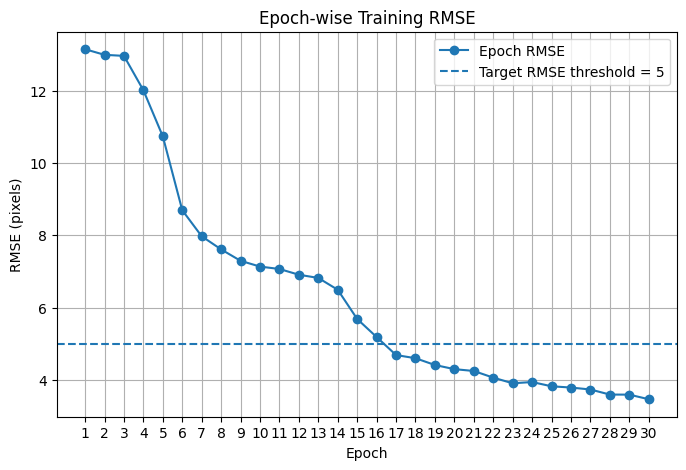

In [7]:
rmse_values = np.array(hist["rmse"])
batches_per_epoch = len(make_loader())
epochs = len(rmse_values) // batches_per_epoch
epoch_rmse = rmse_values.reshape(epochs, batches_per_epoch).mean(axis=1)
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs+1), epoch_rmse, marker='o', label='Epoch RMSE')
plt.axhline(5.0, linestyle='--', label='Target RMSE threshold = 5')
plt.xlabel('Epoch')
plt.ylabel('RMSE (pixels)')
plt.title('Epoch-wise Training RMSE')
plt.xticks(np.arange(1, epochs+1))
plt.legend()
plt.grid(True)
plt.show()

Let's now visualize on 6 samples if our predictions match the true centers of the odd shapes:

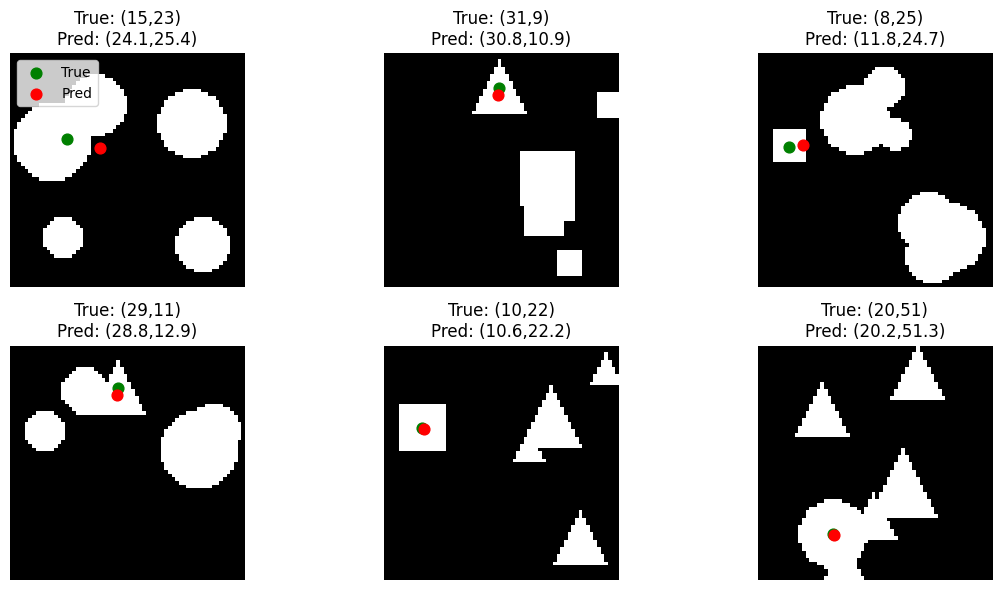

In [15]:
n = 6
ds = OddXYDataset(length=10_000)
loader = DataLoader(ds, batch_size=n, shuffle=True)
imgs_cpu, trues_cpu = next(iter(loader))    # imgs_cpu: (n,1,64,64); trues_cpu: (n,2)

net = net.to(device).eval()
with torch.no_grad():
    imgs_gpu = imgs_cpu.to(device)
    preds_gpu, _, _, _ = net(imgs_gpu)       # preds_gpu: (n,2)
    preds_cpu = preds_gpu.cpu()

plt.figure(figsize=(12, 6))
for i in range(n):
    ax = plt.subplot(2, 3, i+1)
    img = imgs_cpu[i,0].numpy()
    tx, ty = trues_cpu[i].numpy()
    px, py = preds_cpu[i].numpy()

    ax.imshow(img, cmap="gray", vmin=0, vmax=1)
    ax.scatter(tx, ty, c="green", s=60, marker="o", label="True")
    ax.scatter(px, py, c="red",   s=60, marker="o", label="Pred")
    ax.set_title(f"True: ({tx:.0f},{ty:.0f})\nPred: ({px:.1f},{py:.1f})")
    ax.axis("off")
    if i == 0:
        ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

From the above plots we can clearly see that the predictions and true values almost coincide. The picture in the top left corner seems to be an exception because it looks like the odd shape is covered by a normal shape, hence the issue to predict its exact location. "Note that these shapes may overlap partially or even completely, potentially hiding the odd shape."

Let's now visualize the attention diagrams:

In [11]:
class OddNetWithAttn(OddNet):
    def forward(self, x):
        tok = self.pos(self.patch(x))           # (B,144,dim)
        all_attn = []                           # ← collect per-layer weights

        for layer in self.tr.layers:
            #   attn_out:   (B,144,dim)
            #   attn_weights: (B, heads, 144, 144)
            attn_out, attn_weights = layer.self_attn(
                layer.norm1(tok),
                layer.norm1(tok),
                layer.norm1(tok),
                need_weights=True,
                average_attn_weights=False
            )
            tok = tok + layer.dropout1(attn_out)
            tok = tok + layer.dropout2(layer.linear2(layer.dropout(layer.activation(layer.linear1(layer.norm2(tok))))))
            all_attn.append(attn_weights)

        logits = self.prob_head(tok).squeeze(-1)
        prob   = torch.softmax(logits,1)
        coarse = prob @ self.centres
        offset = self.offset_head(tok)
        fine   = (prob.unsqueeze(-1)*offset).sum(1)
        pred   = coarse + fine

        return pred, logits, prob, offset, all_attn

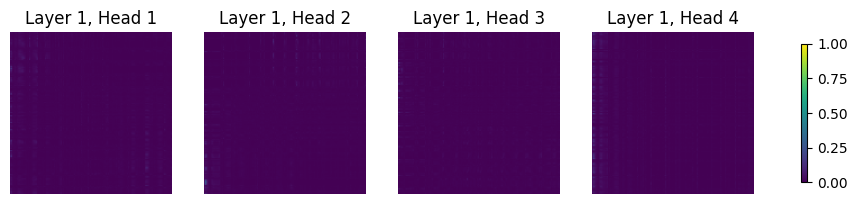

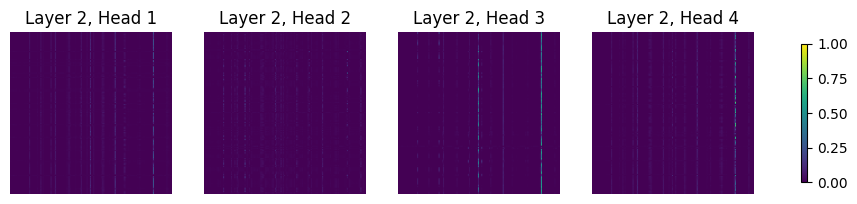

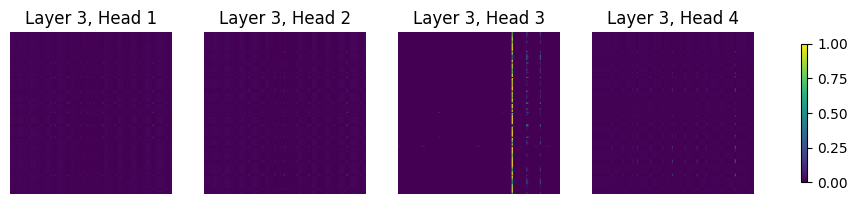

In [12]:
net_attn = OddNetWithAttn()
net_attn.load_state_dict(net.state_dict())

net_attn = net_attn.to(device).eval()

imgs_cpu, _ = next(iter(DataLoader(OddXYDataset(), batch_size=6, shuffle=True)))

with torch.no_grad():
    preds, logits, prob, offset, all_attn = net_attn(imgs_cpu.to(device))

sample = 0
L = len(all_attn)
H = all_attn[0].shape[1]

for layer_idx, A in enumerate(all_attn):
    fig, axes = plt.subplots(1, H, figsize=(3*H, 3))
    for h in range(H):
        ax = axes[h]
        im = ax.imshow(A[sample, h].cpu(), vmin=0, vmax=1, cmap="viridis")
        ax.set_title(f"Layer {layer_idx+1}, Head {h+1}")
        ax.axis("off")
    fig.colorbar(im, ax=axes, shrink=0.6)
    plt.show()

What can we observe? Let's break it down into layers:

Layer 1: Almost Uniform, No Clear Focus
- Across all four heads in the first layer, the attention matrices are essentially just purple squares. That tells us that early on, every patch token is sharing information equally with every other patch. The model hasn’t yet learned to discriminate “odd” from “majority,” so it relies on a fully mixed, global representation. There are no visible spikes or stripes — just a uniform background. At this stage the network is still building generic, low-level features (edges, textures) across the entire image. No head has specialized to look for odd shapes yet.

Layer 2: We now see hints of localization
- In the second layer we begin to see the faint vertical lines at specific column indices — each line corresponds to a particular token (i.e. one of the 144 patches). Those thin streaks suggest that some heads are starting to pay a bit more attention to certain patches — likely ones containing strong shape edges or the odd object. Head 1 and Head 2 are still mostly uniform, with only the palest ridges at a few columns. For Head 3 and Head 4 you can just make out slightly brighter lines at what seems to be the odd-shape token’s index.

Layer 3: One Specialist Emerges
- By the third (final) layer, Head 3 shows a striking bright stripe at exactly the token index of the odd shape (the yellow vertical line in your visualization). That head is now laser-focused: it assigns nearly all of its weight to the single “odd” patch. Head 1, Head 2 and Head 4 remain mostly diffuse — either they never specialized or they’re carrying other, complementary contextual roles. Nevertheless, Head 3 is a true “odd-shape detector,” pinpointing the unique token.

It seems that the model has learned to solve the task by allocating one head to do the heavy lifting of locating the odd patch, while other heads continue aggregating background or positional cues.

Other observations:
- Why only one head? The fact that only Head 3 in the last layer specializes may mean the other heads weren’t necessary for this simple odd-shape detection — they might encode redundancy or help with gradient flow.
- Residual faint stripes in other heads could be positional biases (e.g. center-bias) rather than content awareness.
- Uniform Heads may still be important: a flat distribution ensures the odd-shape head has a stable global context to compare against.